# E-Commerce Data Analysis: Exploratory Data Analysis (EDA)

**Author:** Saraswathi R  
**Last Updated:** 22-07-2025  
**Description:** Comprehensive EDA of e-commerce transaction data, including data cleaning, visualization, and initial insights.

## Table of Contents
1. [Setup and Data Loading](#1-Setup-and-Data-Loading)
2. [Initial Data Exploration](#2-Initial-Data-Exploration)
3. [Data Cleaning](#3-Data-Cleaning)
4. [Exploratory Analysis](#4-Exploratory-Analysis)
   - 4.1 [Time-Based Analysis](#41-Time-Based-Analysis)
   - 4.2 [Product Analysis](#42-Product-Analysis)
   - 4.3 [Customer Analysis](#43-Customer-Analysis)
   - 4.4 [Geographical Analysis](#44-Geographical-Analysis)
5. [Summary and Conclusions](#5-Summary-and-Conclusions)
6. [Next Steps](#6-Next-Steps)

## Setup and Data Loading

### Data Source and Preprocessing

#### Data Source
- **Primary Source**: Kaggle "ecommerce-data" dataset
- **Format**: Initially CSV, processed into Parquet format
- **ETL Pipeline**: Processed through Airflow DAG ([ecomm_invoice_etl_dag.py](cci:7://file:///e:/Smartcart_Retail_Analytics/src/dags/ecomm_invoice_etl_dag.py:0:0-0:0))

#### Data Cleaning (Performed in ETL)
1. **Missing Values**:
   - Empty `Description` → Filled with 'No Description'
   - Missing `CustomerID` → Set to 0

2. **Data Type Standardization**:
   - `InvoiceDate`: Converted to datetime
   - `StockCode`: Converted to string and standardized to uppercase
   - `CustomerID`: Converted to integer (missing values → 0)
   - `Description`: Ensured string type and standardized per `StockCode`

3. **Derived Column**:
   - `total_spend`: Calculated as `Quantity * UnitPrice`

4. **Data Quality Notes**:
   - Special `StockCode` values:
     - 'M' may indicate manual adjustments
     - Invoice numbers starting with 'C' indicate credit notes/returns
   - Descriptions have been standardized to the most frequent version per `StockCode`

#### Why Use the Parquet File?
1. **Efficiency**: 
   - Smaller file size than CSV
   - Faster read/write operations
   - Preserves data types (no need to re-parse dates/numbers)

2. **Consistency**:
   - Ensures everyone uses the same cleaned version
   - Removes need to reimplement cleaning logic

3. **Reproducibility**:
   - Contains all cleaning steps in one place
   - Version controlled through the ETL pipeline

In [13]:
import numpy as np
import pandas as pd
# import requests
# import io

In [14]:
# use encoding = 'latin1' because the data has a ( a currency sign lie $ ) that make it hard to be read without encoding.
# reading the uncleaned raw data.csv file
# df= pd.read_csv(r"E:\Smartcart_Retail_Analytics\data\uncleaned_data.csv", encoding= 'latin1')

In [15]:
# Standard library imports
import os
from datetime import datetime


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

# Visualization settings
%matplotlib inline
sns.set_theme()
sns.set_palette('viridis')
pd.set_option('display.max_columns', None) # to show all the columns
pd.set_option('display.float_format', lambda x: '%.2f' % x) # setting all floating point numbers to 2 decimal places

# Set random seed for reproducibility
np.random.seed(42)

def load_data(filepath):
    """
    Load data from the specified file path.
    
    Args:
        filepath (str): Path to the data file
        
    Returns:
        pd.DataFrame: Loaded DataFrame
    """
    try:
        if filepath.endswith('.parquet'):  # parquet is a binary file format
            return pd.read_parquet(filepath)
        elif filepath.endswith('.csv'):  # csv is a text file format
            return pd.read_csv(filepath, encoding='latin1')
        else:
            raise ValueError("Unsupported file format. Please use .csv or .parquet")
    except Exception as e: # stores the error in variable e
        print(f"Error loading data: {e}")
        return None

# Load the data
print("Loading data...")
data_path = "E:\Smartcart_Retail_Analytics\data\ecomm_invoice_transaction.parquet"
df = load_data(data_path)

# Display basic information
print("\n=== Data Loaded Successfully ===")
print(f"Shape: {df.shape}")
display(df.head())

Loading data...

=== Data Loaded Successfully ===
Shape: (541909, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_spend
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


## Initial Data Exploration

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

In [16]:
def initial_exploration(df):
    """
    Perform initial exploration of the dataset.
    
    Args:
        df (pd.DataFrame): Input DataFrame
    """
    print("=== Dataset Overview ===")
    print(f"Number of rows: {df.shape[0]}")
    print(f"Number of columns: {df.shape[1]}")
    
    print("\n=== Column Data Types ===")
    print(df.dtypes)

    print("\n=== First 5 Rows ===")
    display(df.head())


    # Identify numerical and categorical columns
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    datetime_cols = df.select_dtypes(include=['datetime64']).columns
    
    print("\n=== Numerical Columns Statistics ===")
    if not numeric_cols.empty:
        display(df[numeric_cols].describe().T)
    else:
        print("No numerical columns found.")
    
    print("\n=== Categorical Columns Statistics ===")
    if not categorical_cols.empty:
        display(df[categorical_cols].describe(include='O').T)
    else:
        print("No categorical columns found.")
        
    print("\n=== Datetime Columns Statistics ===")
    if not datetime_cols.empty:
        for col in datetime_cols:
            print(f"\nColumn: {col}")
            print(f"Min date: {df[col].min()}")
            print(f"Max date: {df[col].max()}")
            print(f"Unique dates: {df[col].nunique()}")
    else:
        print("No datetime columns found.")
    
    
    print("\n=== Missing Values ===")
    missing = df.isnull().sum()
    missing_percent = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Values': missing,
        'Percentage (%)': missing_percent
    })
    display(missing_df[missing_df['Missing Values'] > 0])
    

    print("\n=== Duplicate Rows ===")
    print(f"Number of duplicate rows: {df.duplicated().sum()}")

    print("\n=== Unique Values per Column ===")
    for col in df.columns:
        print(f"{col}: {df[col].nunique():,} unique values")

# Run the exploration
print("Performing initial data exploration...")
initial_exploration(df)

Performing initial data exploration...
=== Dataset Overview ===
Number of rows: 541909
Number of columns: 9

=== Column Data Types ===
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int64
Country                object
total_spend           float64
dtype: object

=== First 5 Rows ===


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_spend
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34



=== Numerical Columns Statistics ===


,count,mean,std,min,25%,50%,75%,max
Quantity,541909.00,9.55,218.08,-80995.00,1.00,3.00,10.00,80995.00
UnitPrice,541909.00,4.61,96.76,-11062.06,1.25,2.08,4.13,38970.00
CustomerID,541909.00,11476.97,6777.91,0.00,12352.00,14382.00,16255.00,18287.00
total_spend,541909.00,17.99,378.81,-168469.60,3.40,9.75,17.40,168469.60



=== Categorical Columns Statistics ===


,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,3958,85123A,2380
Description,541909,3800,WHITE HANGING HEART T-LIGHT HOLDER,2380
Country,541909,38,United Kingdom,495478



=== Datetime Columns Statistics ===

Column: InvoiceDate
Min date: 2010-12-01 08:26:00
Max date: 2011-12-09 12:50:00
Unique dates: 23260

=== Missing Values ===


,Missing Values,Percentage (%)



=== Duplicate Rows ===
Number of duplicate rows: 5270

=== Unique Values per Column ===
InvoiceNo: 25,900 unique values
StockCode: 3,958 unique values
Description: 3,800 unique values
Quantity: 722 unique values
InvoiceDate: 23,260 unique values
UnitPrice: 1,630 unique values
CustomerID: 4,373 unique values
Country: 38 unique values
total_spend: 6,204 unique values


## Data Cleaning

In [17]:
def clean_data(df):
    """
    Clean the e-commerce transaction data.
    
    Args:
        df (pd.DataFrame): Raw input data
        
    Returns:
        pd.DataFrame: Cleaned data
    """
    df_clean = df.copy()

    # Assumption: InvoiceDate should be in datetime format
    # If not, conversion will be attempted

    # Check current type of the InvoiceDate column
    # print("Current type:", df_clean['InvoiceDate'].dtype)
    
    # 1. Convert InvoiceDate to datetime
    # df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
    
    # 2. Create time-based features
    df_clean['Year'] = df_clean['InvoiceDate'].dt.year
    df_clean['Month'] = df_clean['InvoiceDate'].dt.month
    df_clean['Day'] = df_clean['InvoiceDate'].dt.day
    df_clean['DayOfWeek'] = df_clean['InvoiceDate'].dt.dayofweek
    df_clean['Hour'] = df_clean['InvoiceDate'].dt.hour
    df_clean['MonthYear'] = df_clean['InvoiceDate'].dt.to_period('M')
    
    # 3. Create total_spend if it doesn't exist
    if 'total_spend' not in df_clean.columns:
        df_clean['total_spend'] = df_clean['Quantity'] * df_clean['UnitPrice']
    
    # 4. Handle returns (negative quantities)
    df_clean['IsReturn'] = df_clean['Quantity'] < 0
    
    print("Data cleaning completed.")
    return df_clean

# Clean the data
print("Cleaning data...")
df_clean = clean_data(df)

# Display cleaned data info
print("\n=== Cleaned Data Info ===")
print(f"Number of transactions after cleaning: {len(df_clean):,}")
print(f"Number of features: {len(df_clean.columns)}")
print("\nFirst few rows of cleaned data:")
display(df_clean.head())

Cleaning data...
Data cleaning completed.

=== Cleaned Data Info ===
Number of transactions after cleaning: 541,909
Number of features: 16

First few rows of cleaned data:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_spend,Year,Month,Day,DayOfWeek,Hour,MonthYear,IsReturn
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010,12,1,2,8,2010-12,False
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,1,2,8,2010-12,False
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010,12,1,2,8,2010-12,False
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,1,2,8,2010-12,False
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,1,2,8,2010-12,False


## Exploratory Analysis


### Time-Based Analysis

In [ ]:
# daily
# monthly
# hourly
# day of the week
# weekday Vs weekend

Analyzing sales trends...


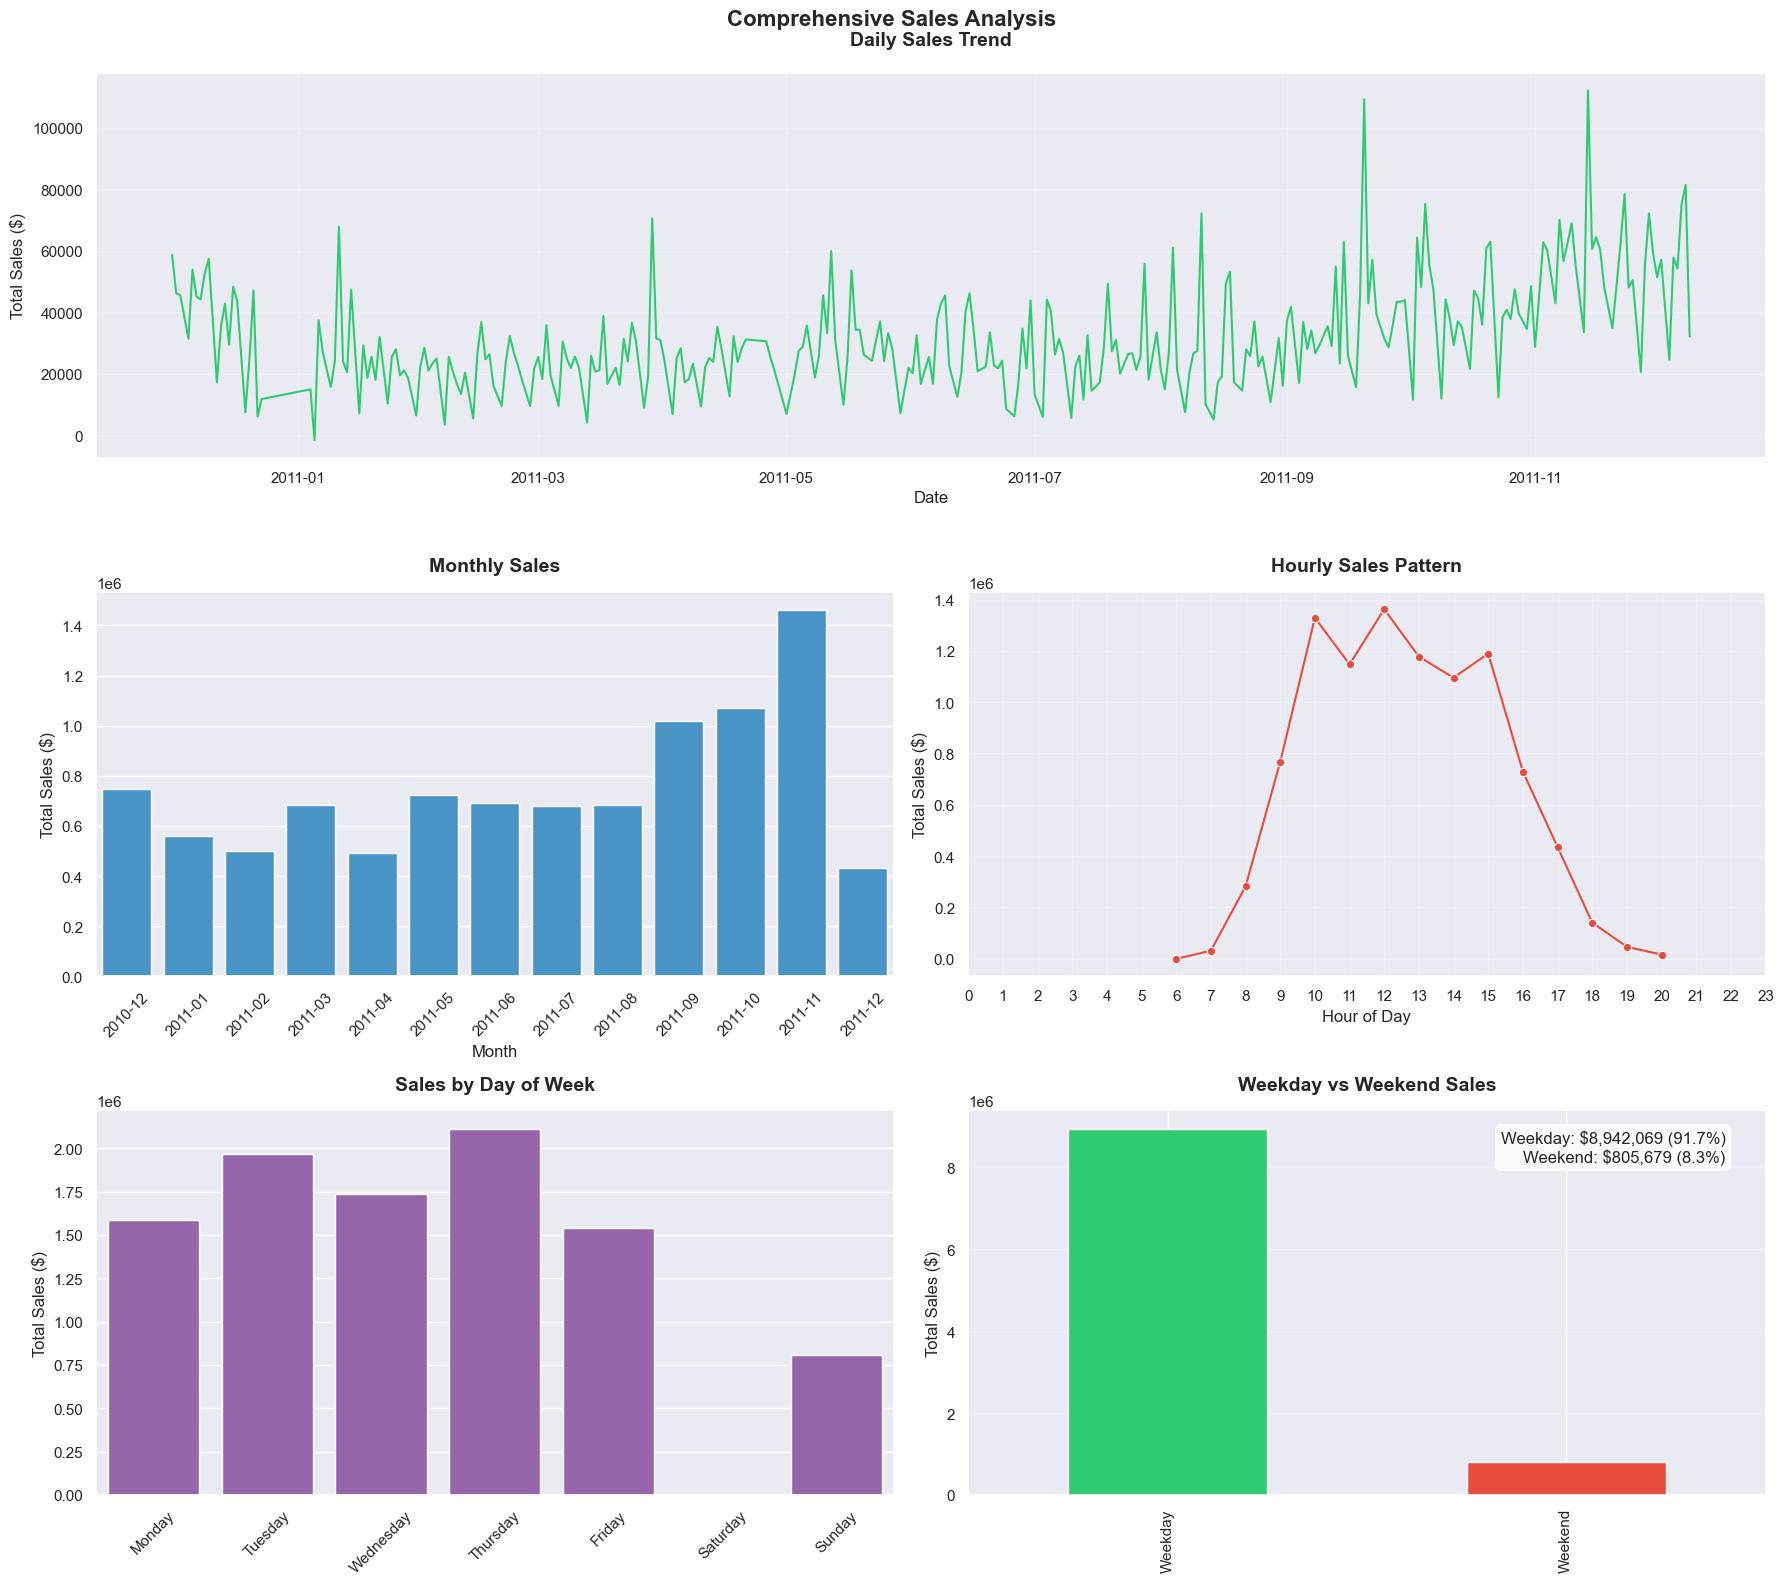

In [6]:
def plot_sales_trends(df):
    """
    Plot comprehensive sales trends over time with multiple visualizations.
    
    Parameters:
    df (DataFrame): DataFrame containing sales data with 'InvoiceDate' and 'total_spend' columns
    """
    
    # Create figure with subplots
    fig = plt.figure(figsize=(18, 16))
    gs = fig.add_gridspec(3, 2)
    
    # 1. Daily Sales Trend
    ax1 = fig.add_subplot(gs[0, :])
    daily_sales = df.groupby(df['InvoiceDate'].dt.date)['total_spend'].sum()
    daily_sales.plot(ax=ax1, color='#2ecc71', linewidth=1.5)
    ax1.set_title('Daily Sales Trend', pad=20, fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Total Sales ($)')
    ax1.grid(True, alpha=0.3)
    
    # 2. Monthly Sales
    ax2 = fig.add_subplot(gs[1, 0])
    monthly_sales = df.groupby('MonthYear')['total_spend'].sum().reset_index()
    monthly_sales['MonthYear'] = monthly_sales['MonthYear'].astype(str)
    sns.barplot(x='MonthYear', y='total_spend', data=monthly_sales, 
                ax=ax2, color='#3498db')
    ax2.set_title('Monthly Sales', pad=15, fontsize=14, fontweight='bold')
    ax2.set_xlabel('Month')
    ax2.set_ylabel('Total Sales ($)')
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Hourly Sales Pattern
    ax3 = fig.add_subplot(gs[1, 1])
    df['Hour'] = df['InvoiceDate'].dt.hour
    hourly_sales = df.groupby('Hour')['total_spend'].sum()
    sns.lineplot(x=hourly_sales.index, y=hourly_sales.values, 
                 ax=ax3, color='#e74c3c', marker='o')
    ax3.set_title('Hourly Sales Pattern', pad=15, fontsize=14, fontweight='bold')
    ax3.set_xlabel('Hour of Day')
    ax3.set_ylabel('Total Sales ($)')
    ax3.set_xticks(range(24))
    ax3.grid(True, alpha=0.3)
    
    # 4. Day of Week Analysis
    ax4 = fig.add_subplot(gs[2, 0])
    df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    df['DayOfWeek'] = pd.Categorical(df['DayOfWeek'], categories=day_order, ordered=True)
    daily_sales = df.groupby('DayOfWeek')['total_spend'].sum()
    sns.barplot(x=daily_sales.index, y=daily_sales.values, ax=ax4, color='#9b59b6')
    ax4.set_title('Sales by Day of Week', pad=15, fontsize=14, fontweight='bold')
    ax4.set_xlabel('')
    ax4.set_ylabel('Total Sales ($)')
    ax4.tick_params(axis='x', rotation=45)
    
    # 5. Weekday vs Weekend
    ax5 = fig.add_subplot(gs[2, 1])
    # dt.weekday returns 0-6 (Monday=0, Sunday=6), so < 5 means Monday-Friday
    df['DayType'] = np.where(df['InvoiceDate'].dt.weekday < 5, 'Weekday', 'Weekend')
    daytype_sales = df.groupby('DayType')['total_spend'].sum()
    colors = ['#2ecc71', '#e74c3c']
    daytype_sales.plot(kind='bar', ax=ax5, color=colors)
    ax5.set_title('Weekday vs Weekend Sales', pad=15, fontsize=14, fontweight='bold')
    ax5.set_xlabel('')
    ax5.set_ylabel('Total Sales ($)')
    ax5.grid(axis='y', alpha=0.3)
    
    # Add some statistics as text
    weekday_total = daytype_sales.get('Weekday', 0) # Gets Weekday sales or 0 if not found
    weekend_total = daytype_sales.get('Weekend', 0)
    # Calculate percentage of total sales that occurred on weekdays
    weekday_pct = (weekday_total / (weekday_total + weekend_total)) * 100
    stats_text = f"Weekday: ${weekday_total:,.0f} ({weekday_pct:.1f}%)\n"
    stats_text += f"Weekend: ${weekend_total:,.0f} ({(100 - weekday_pct):.1f}%)"
    
    ax5.text(0.95, 0.95, stats_text, transform=ax5.transAxes,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    # 0.95, 0.95 are the coordinates of the text (95% from the left and top)
    # stats_text --> The text to display
    # transform=ax5.transAxes --> Use axis coordinates (0-1) instead of data coordinates
    # verticalalignment='top' --> Aligns the text to the top of the axes
    # horizontalalignment='right' --> Aligns the text to the right of the axes
    # bbox=dict(boxstyle='round', facecolor='white', alpha=0.8) --> Adds a white background with a round border to the text
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.suptitle('Comprehensive Sales Analysis', fontsize=16, fontweight='bold', y=0.99)
    
    # Save the figure
    plt.savefig('time_based_sales_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Return the modified dataframe with new temporal features
    return df

# Plot sales trends
print("Analyzing sales trends...")
df_clean = plot_sales_trends(df_clean)

### Product analysis

In [8]:
# Summary of the following action:
# 1. Creating column Is_Return to identify return transactions
# 2. Creating column Net_Quantity to convert returns to 0 for sales analysis
# 3. Overall metrics
# 4. Sales Analysis (Positive Quantities)
        # Top selling products by quantity
        # Top products by revenue
# 5. Returns Analysis (Negative Quantities)
        # Top returns
        # Return rate by product
        # products with significant sales (more than 100 units)
        # products with highest return rates        
# 6. Price Distribution Analysis
# 7. Price vs. Return Rate Analysis


Analyzing product data...
=== Overall Product Metrics ===
Total unique products: 3,958
Total transactions: 541,909
Return transactions: 10,624 (2.0%)

=== Sales Analysis (Positive Quantities) ===
Total items sold: 5,660,981


C:\Users\shanu\AppData\Local\Temp\ipykernel_11704\2230083824.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_products_qty.values, y=top_products_qty.index, palette='viridis')


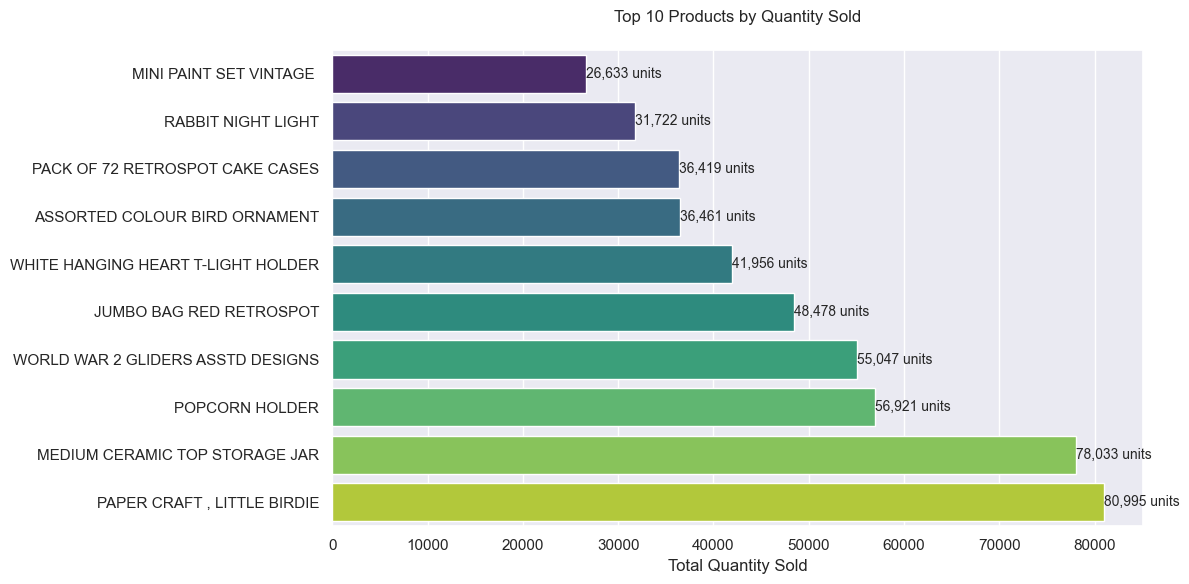

C:\Users\shanu\AppData\Local\Temp\ipykernel_11704\2230083824.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_products_rev.values,


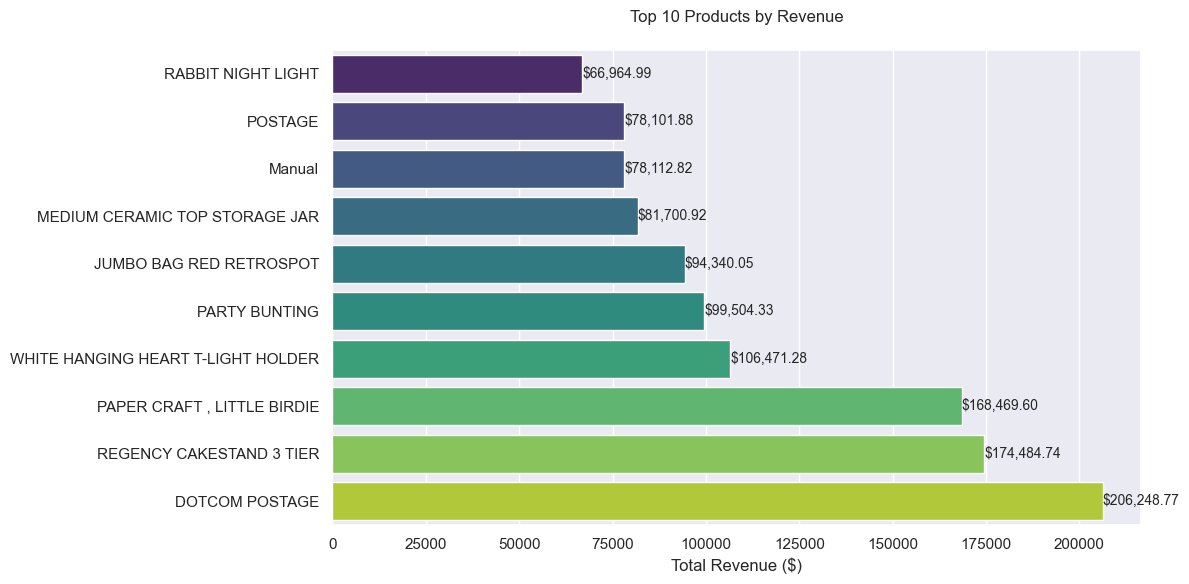


=== Returns Analysis (Negative Quantities) ===


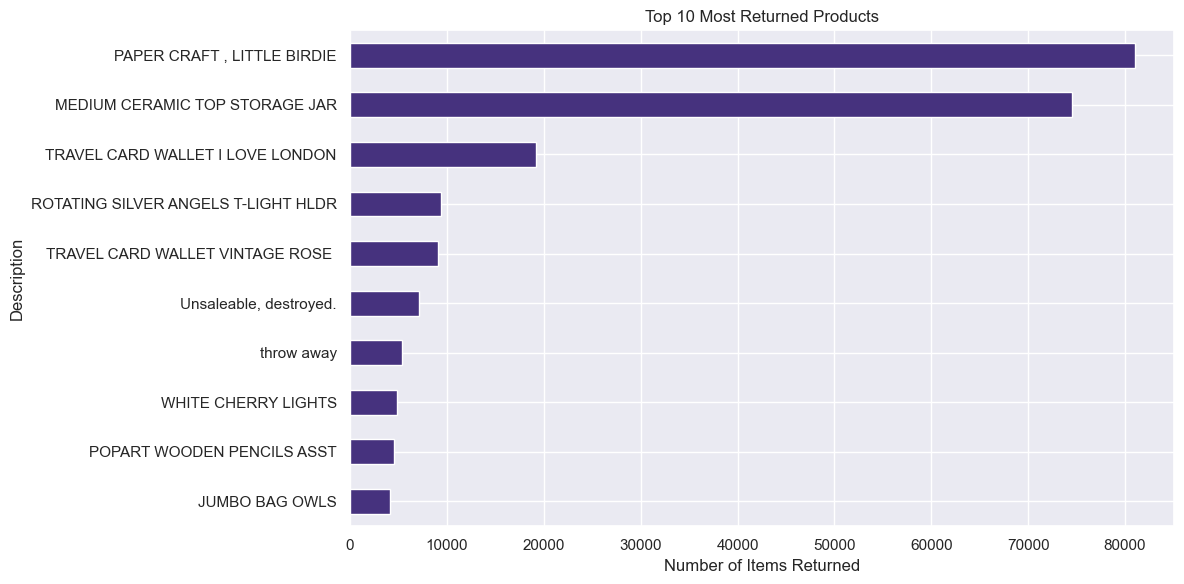

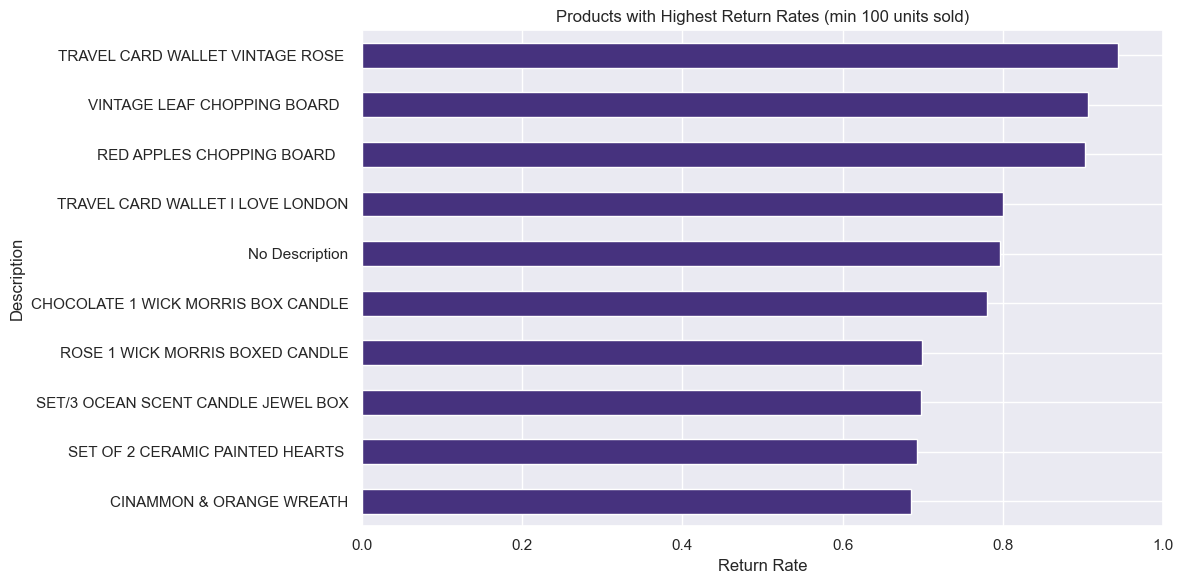


=== Price Distribution ===


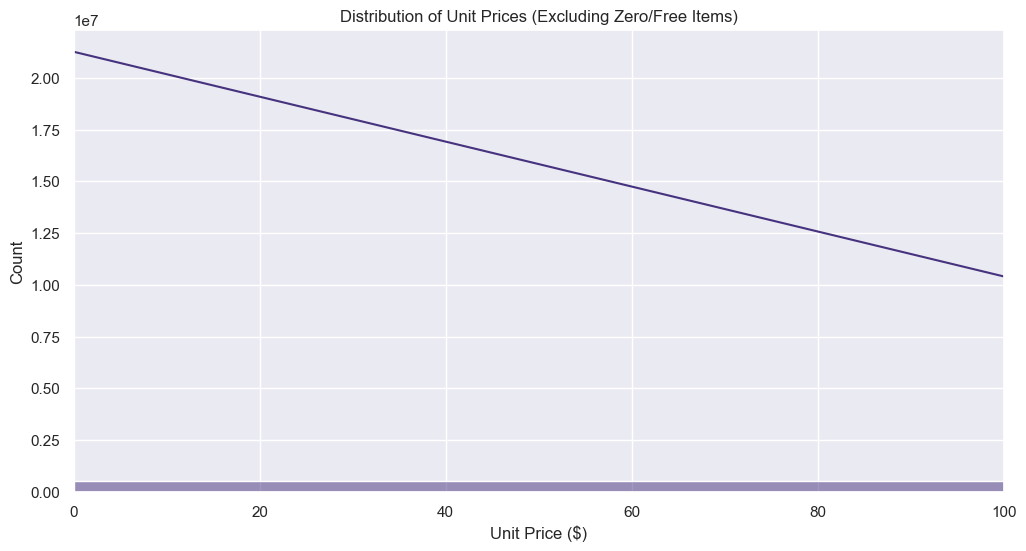


=== Price vs. Return Rate ===


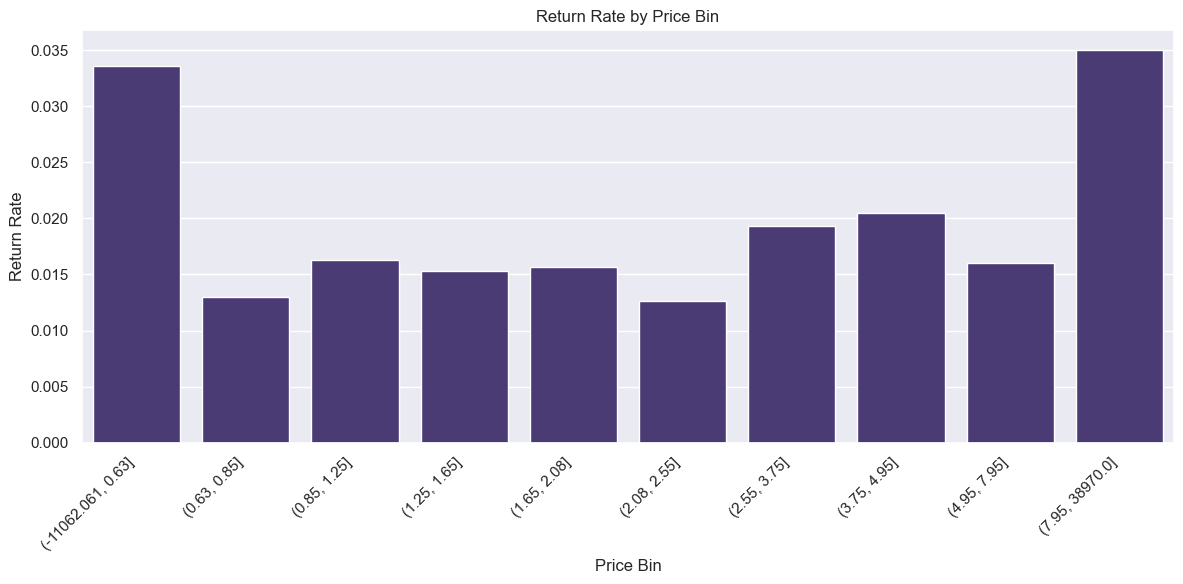

In [9]:
## Product Analysis

def analyze_products(df):
    """
    Analyze product performance including sales and returns.
    Separates analysis of positive quantities (sales) and negative quantities (returns).
    """
    # Create a copy to avoid SettingWithCopyWarning
    df_products = df.copy()
    
    # What Negative Quantities Mean:
        # Returns: When a customer returns an item
        # Cancellations: When an order is canceled after being recorded
        # Adjustments: Manual corrections to inventory

    # Create flags and net quantity for analysis
    df_products['Is_Return'] = df_products['Quantity'] < 0
    df_products['Net_Quantity'] = df_products['Quantity'].clip(lower=0)  
    # Convert returns to 0 for sales analysis to ignore the returns 
    # For each value:
        # If the value is negative, it changes it to 0
        # If the value is positive or zero, it keeps the original value
     
    # 1. Overall Metrics
    print("=== Overall Product Metrics ===")
    total_products = df_products['StockCode'].nunique()
    total_transactions = len(df_products)
    return_transactions = df_products['Is_Return'].sum()
    
    print(f"Total unique products: {total_products:,}")
    print(f"Total transactions: {total_transactions:,}")
    print(f"Return transactions: {return_transactions:,} ({return_transactions/total_transactions:.1%})")
    
    # 2. Sales Analysis (Positive Quantities)
    print("\n=== Sales Analysis (Positive Quantities) ===")
    # Filter out returns and keep only necessary columns
    sales = df_products[~df_products['Is_Return']].copy() 
    # The ~ (tilde) is a logical NOT operator. It flips all the True/False values.
    # df_products['Is_Return'] means return transactions
    # ~df_products['Is_Return'] means not return transactions
    # This gives only the actual sales after eliminating the returns
    sales = sales[['Description', 'Net_Quantity', 'UnitPrice', 'total_spend']]
    
    # Now we can safely use Net_Quantity which is the same as Quantity but more explicit
    print(f"Total items sold: {sales['Net_Quantity'].sum():,}")

    # Top selling products by quantity
    top_products_qty = sales.groupby('Description')['Net_Quantity'].sum().nlargest(10).sort_values()
    
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=top_products_qty.values, y=top_products_qty.index, palette='viridis')
    # Add value labels
    for i, v in enumerate(top_products_qty):
        ax.text(v + 5, i, f'{v:,.0f} units', va='center', ha='left', fontsize=10)
    plt.title('Top 10 Products by Quantity Sold', pad=20)
    plt.xlabel('Total Quantity Sold')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()
    
    # Top products by revenue
    sales['Revenue'] = sales['Net_Quantity'] * sales['UnitPrice']
    top_products_rev = sales.groupby('Description')['Revenue'].sum().nlargest(10).sort_values()
    
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=top_products_rev.values, 
                y=top_products_rev.index, 
                palette='viridis')

    # Add value labels
    for i, v in enumerate(top_products_rev):
        ax.text(v + 10, i, f'${v:,.2f}', 
            va='center', ha='left',
            fontsize=10)
    plt.title('Top 10 Products by Revenue', pad=20)
    plt.xlabel('Total Revenue ($)')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()


    
    # 3. Returns Analysis (Negative Quantities)
    print("\n=== Returns Analysis (Negative Quantities) ===")
    returns = df_products[df_products['Is_Return']].copy()
    
    if not returns.empty:
        # Most returned products
        top_returns = returns.groupby('Description')['Quantity'].sum().nsmallest(10)  # nsmallest because returns are negative
        
        plt.figure(figsize=(12, 6))
        (-top_returns).sort_values().plot(kind='barh')  # Convert to positive for display
        plt.title('Top 10 Most Returned Products')
        plt.xlabel('Number of Items Returned')
        plt.tight_layout()
        plt.show()
        
        # Return rate by product (for products with at least 100 units sold)
        product_stats = df_products.groupby('Description').agg({
            'Quantity': [('Total_Sold', lambda x: x[x>0].sum()),
                        ('Total_Returned', lambda x: -x[x<0].sum())]  # Convert returns to positive
        })
        # When we used .agg() with multiple aggregation functions, pandas created a MultiIndex for the columns.
        # Level 0: 'Quantity'         'Quantity'
        # Level 1: 'Total_Sold'       'Total_Returned'
        # columns.droplevel(0): Removes the first level of the column index
        # Now columns are just: 'Total_Sold' and 'Total_Returned'
        product_stats.columns = product_stats.columns.droplevel(0)
        product_stats = product_stats.fillna(0)

        # Calculate return rate: returns / (sales + returns)
        product_stats['Return_Rate'] = (product_stats['Total_Returned'] / 
                                      (product_stats['Total_Sold'] + product_stats['Total_Returned']))
        
        # Filter for products with significant sales
        # Focus on products with significant sales (more than 100 units)
        # Get the 10 products with highest return rates
        significant_products = product_stats[product_stats['Total_Sold'] > 100]
        high_return_products = significant_products.nlargest(10, 'Return_Rate')
        
        plt.figure(figsize=(12, 6))
        high_return_products['Return_Rate'].sort_values().plot(kind='barh')
        plt.title('Products with Highest Return Rates (min 100 units sold)')
        plt.xlabel('Return Rate')
        plt.xlim(0, 1)
        plt.tight_layout()
        plt.show()
    else:
        print("No return transactions found in the dataset.")
    
    # 4. Price Distribution Analysis
    print("\n=== Price Distribution ===")
    plt.figure(figsize=(12, 6))
    # Only includes items with positive prices
    # This excludes free items (price = 0) and any potential negative prices
    sns.histplot(df_products[df_products['UnitPrice'] > 0]['UnitPrice'], bins=50, kde=True)
    plt.title('Distribution of Unit Prices (Excluding Zero/Free Items)')
    plt.xlim(0, 100)  # Limit x-axis for better visualization, Focuses on the main price range (excludes very high outliers)
    plt.xlabel('Unit Price ($)')
    plt.show()
    
    # 5. Price vs. Return Rate Analysis
    if not returns.empty:
        print("\n=== Price vs. Return Rate ===")
        # Bin products by price
        # pd.qcut() is a function that splits the data into quantiles (equal parts)
        # q=10 means it will split the data into 10 equal parts
        # duplicates='drop' means it will drop any duplicates
        df_products['Price_Bin'] = pd.qcut(df_products['UnitPrice'], 
                                         q=10, 
                                         duplicates='drop')
        
        # In each price group/ bin, 'Is_Return" boolean column is counted
        # 'count' counts the number of transactions in each bin (both returns(True)and purchases(False))
            # ==> which gives the total trnsactions per bin
        # 'mean' calculates the average return rate in each bin
            # ==> mean= sum of returns(sum of all values--> only true values added up) / total number ofvalues
        price_return = df_products.groupby('Price_Bin').agg({
            'Is_Return': ['count', 'mean']
        })
        price_return.columns = ['Total_Transactions', 'Return_Rate']
        
        plt.figure(figsize=(12, 6))
        # Takes the index of price_return (which are the price bins like "$0-$10")
        # Converts them to strings (just to be safe), These will be the labels on the x-axis

        # price_return is a DataFrame with Price_Bin as index
        # reset_index() makes Price_Bin a regular column
        # This is needed-->  because seaborn needs column names, not index names

        sns.barplot(x=price_return.index.astype(str), y='Return_Rate', data=price_return.reset_index())
        plt.title('Return Rate by Price Bin')
        plt.xlabel('Price Bin')
        plt.ylabel('Return Rate')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

# Run the analysis
print("Analyzing product data...")
analyze_products(df)

### Customer analysis

Analyzing customer behavior...


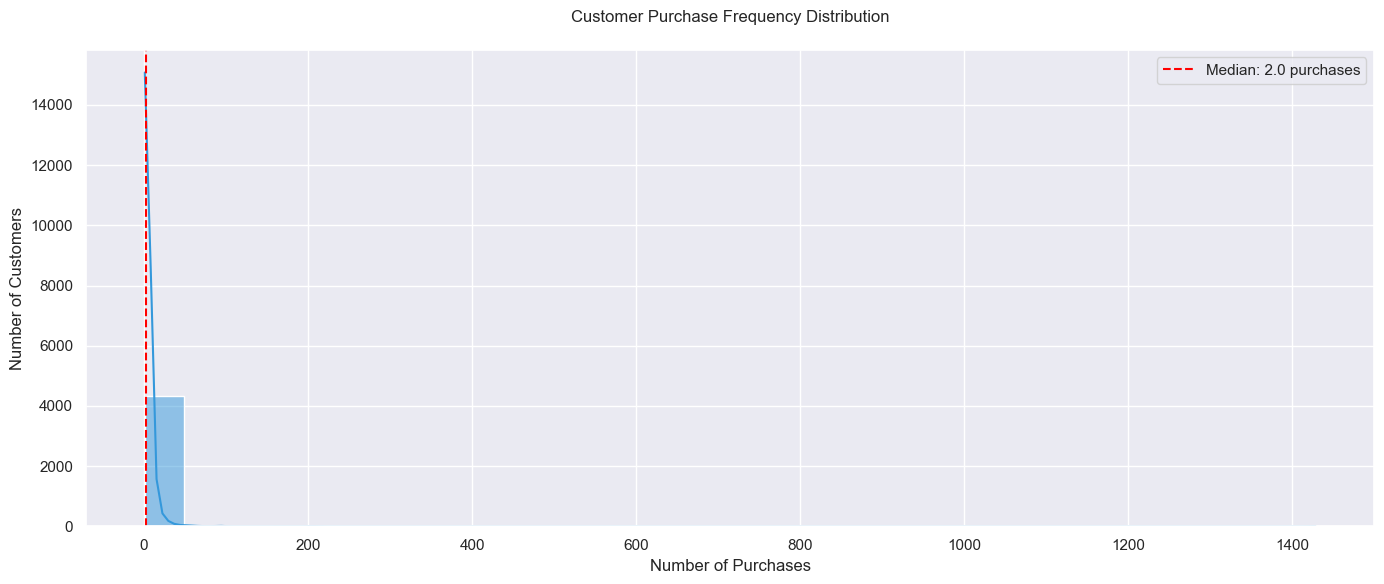

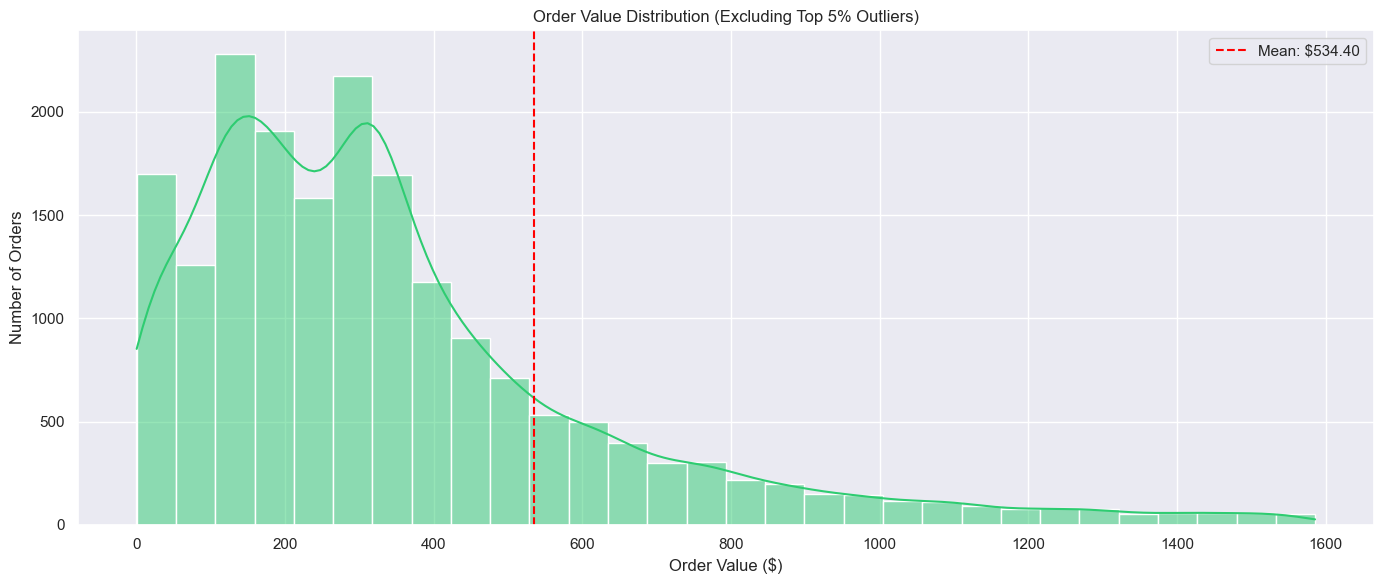


=== Customer Analysis Summary ===
Total Unique Customers: 4,339
Total Orders Placed: 19,960
Repeat Customers: 2,846 (65.6%)
Average Order Value: $534.40
Median Order Value: $303.84


In [10]:
def analyze_customers(df):
    """
    Customer behavior analysis with more metrics and visualizations.
    """
    # 1. Basic customer metrics
    total_customers = df['CustomerID'].nunique()
    total_orders = df['InvoiceNo'].nunique()
    
    # 2. Purchase frequency distribution
    customer_purchases = df.groupby('CustomerID')['InvoiceNo'].nunique()
    repeat_customers = (customer_purchases > 1).sum()
    
    # 3. Plot histogram
    plt.figure(figsize=(14, 6))
    ax = sns.histplot(customer_purchases, 
                     bins=30, 
                     kde=True,
                     color='#3498db')
    
    # Add median line
    median_purchases = customer_purchases.median()
    plt.axvline(median_purchases, color='red', linestyle='--', 
               label=f'Median: {median_purchases:.1f} purchases')
    
    # Add value labels
    #for rect in ax.patches:
    #    if rect.get_height() > 0:
    #        ax.text(rect.get_x() + rect.get_width()/2, 
    #               rect.get_height() + 5, 
    #               f'{int(rect.get_height())}',
    #               ha='center', va='bottom')
    
    plt.title('Customer Purchase Frequency Distribution', pad=20)
    plt.xlabel('Number of Purchases')
    plt.ylabel('Number of Customers')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 4. Calculate and display key metrics
    order_values = df.groupby('InvoiceNo')['total_spend'].sum()
    avg_order_value = order_values.mean()
    median_order_value = order_values.median()
    
    # 5. Plot order value distribution
    plt.figure(figsize=(14, 6))
    sns.histplot(order_values[order_values < order_values.quantile(0.95)],  # Remove top 5% outliers
                bins=30, 
                kde=True,
                color='#2ecc71')
    plt.title('Order Value Distribution (Excluding Top 5% Outliers)')
    plt.xlabel('Order Value ($)')
    plt.ylabel('Number of Orders')
    plt.axvline(avg_order_value, color='red', linestyle='--', 
               label=f'Mean: ${avg_order_value:,.2f}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 6. Print summary statistics
    print("\n=== Customer Analysis Summary ===")
    print(f"Total Unique Customers: {total_customers:,}")
    print(f"Total Orders Placed: {total_orders:,}")
    print(f"Repeat Customers: {repeat_customers:,} ({(repeat_customers/total_customers)*100:.1f}%)")
    print(f"Average Order Value: ${avg_order_value:,.2f}")
    print(f"Median Order Value: ${median_order_value:,.2f}")
    print("="*50)

# Run analysis on non-return transactions
print("Analyzing customer behavior...")
analyze_customers(df_clean[df_clean['total_spend'] > 0])

In [11]:
#country_sales = df.groupby('Country').agg({
 #       'total_spend': ['sum', 'count'],
 #       'CustomerID': 'nunique'
 #   }).sort_values(('total_spend', 'sum'), ascending=False)

# print(country_sales)


Analyzing geographical distribution...

GEOGRAPHICAL ANALYSIS

Top 10 Countries by Revenue:


,Total_Revenue,Order_Count,Unique_Customers,Avg_Order_Value
Country,,,,
United Kingdom,"$8,187,806.36","495,478","3,951",$16.53
Netherlands,"$284,661.54","2,371",9,$120.06
EIRE,"$263,276.82","8,196",4,$32.12
Germany,"$221,698.21","9,495",95,$23.35
France,"$197,403.90","8,557",88,$23.07
Australia,"$137,077.27","1,259",9,$108.88
Switzerland,"$56,385.35","2,002",22,$28.16
Spain,"$54,774.58","2,533",31,$21.62
Belgium,"$40,910.96","2,069",25,$19.77


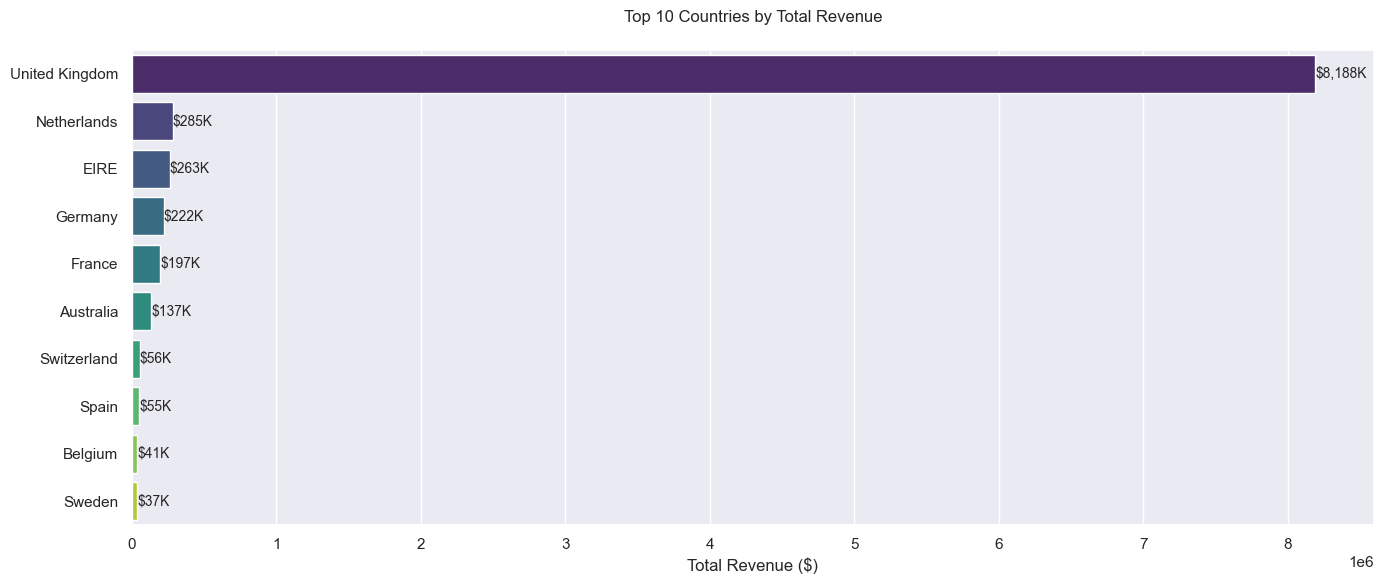

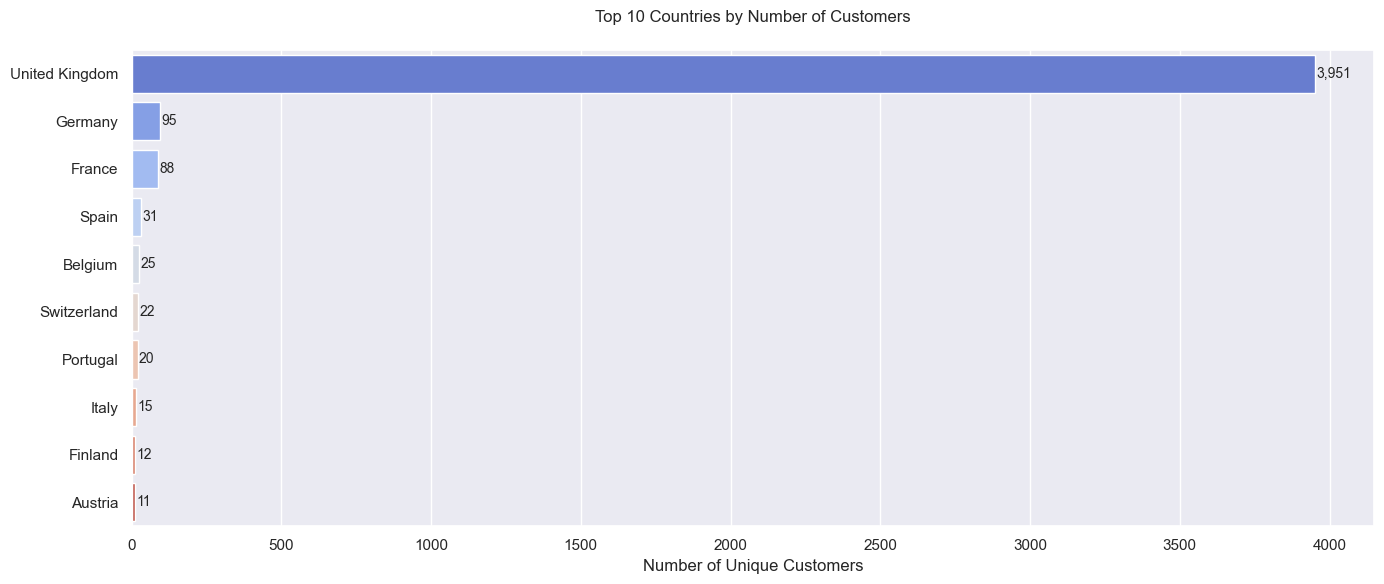

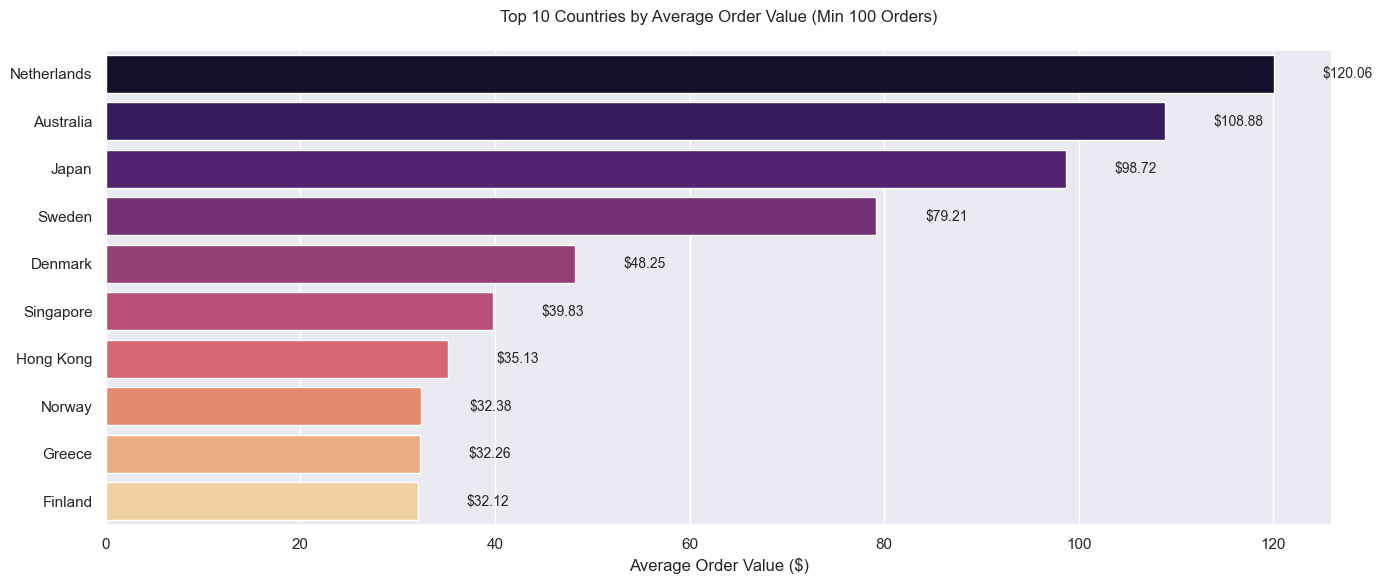

In [12]:
def analyze_geography(df):
    """
    Analyze geographical distribution of sales and customers.
    """
    print("\n" + "="*50)
    print("GEOGRAPHICAL ANALYSIS")
    print("="*50)
    
    # 1. Sales by Country
    # For each country, applying multiple aggregations
    #   'total_spend': sum--> total revenue, count- number of orders
    #   'CustomerID': 'nunique'--> number of unique customers

    # sorting them in descending order(total revenue being the highest first)
    country_sales = df.groupby('Country').agg({
        'total_spend': ['sum', 'count'],
        'CustomerID': 'nunique'
    }).sort_values(('total_spend', 'sum'), ascending=False)
    
    # Clean up column names (the multi-level column names from the groupby are flatterned)
    # Avg_Order_value--> total revenue / number of orders
    #     -->  Example: If a country has $1000 in revenue from 10 orders, AOV = $100
    country_sales.columns = ['Total_Revenue', 'Order_Count', 'Unique_Customers']
    country_sales['Avg_Order_Value'] = country_sales['Total_Revenue'] / country_sales['Order_Count']
    
    # Display top 10 countries by revenue
    print("\nTop 10 Countries by Revenue:")
    display(country_sales.head(10).style.format({
        'Total_Revenue': '${:,.2f}',
        'Avg_Order_Value': '${:,.2f}',
        'Order_Count': '{:,.0f}',
        'Unique_Customers': '{:,.0f}'
    }))
    
    # 2. Plot top countries by revenue
    plt.figure(figsize=(14, 6))
    top_countries = country_sales.head(10).sort_values('Total_Revenue', ascending=False)
    ax = sns.barplot(x='Total_Revenue', y=top_countries.index, data=top_countries, hue= top_countries.index, legend= False, palette='viridis')
    
    # Add value labels
    for i, v in enumerate(top_countries['Total_Revenue']):
        ax.text(v + 1000, i, f'${v/1000:,.0f}K', 
               va='center', fontsize=10)
    
    plt.title('Top 10 Countries by Total Revenue', pad=20)
    plt.xlabel('Total Revenue ($)')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()
    
    # 3. Customers per country
    plt.figure(figsize=(14, 6))
    top_customers = country_sales.sort_values('Unique_Customers', ascending=False).head(10)
    ax = sns.barplot(x='Unique_Customers', y=top_customers.index, 
                    data=top_customers, palette='coolwarm', legend= False, hue= top_customers.index)
    
    # Add value labels
    for i, v in enumerate(top_customers['Unique_Customers']):
        ax.text(v + 5, i, f'{v:,.0f}', 
               va='center', fontsize=10)
    
    plt.title('Top 10 Countries by Number of Customers', pad=20)
    plt.xlabel('Number of Unique Customers')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()
    
    # 4. Average Order Value by Country (for countries with > 100 orders)
    significant_countries = country_sales[country_sales['Order_Count'] > 100]
    significant_countries = significant_countries.sort_values('Avg_Order_Value', ascending=False).head(10)
    
    plt.figure(figsize=(14, 6))
    ax = sns.barplot(x='Avg_Order_Value', y=significant_countries.index, 
                    data=significant_countries, palette='magma', legend= False, hue= significant_countries.index)
    
    # Add value labels
    for i, v in enumerate(significant_countries['Avg_Order_Value']):
        ax.text(v + 5, i, f'${v:,.2f}', 
               va='center', fontsize=10)
    
    plt.title('Top 10 Countries by Average Order Value (Min 100 Orders)', pad=20)
    plt.xlabel('Average Order Value ($)')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()
    
    # 5. Country-wise return rate analysis (if returns data is available)
    if 'Is_Return' in df.columns:
        # df[df['Is_Return']]--> returns only the rows where Is_Return is True and then 
                # counts the number of rows for each country (only returns)

        # df.groupby('Country').size()--> counts the number of rows( total number of orders-- both purchases and returns) for each country
        returns_by_country = df[df['Is_Return']].groupby('Country').size()
        orders_by_country = df.groupby('Country').size()
        return_rates = (returns_by_country / orders_by_country * 100).sort_values(ascending=False).dropna()
        
        if len(return_rates) > 0:
            plt.figure(figsize=(14, 6))
            return_rates_top = return_rates.head(10)
            ax = sns.barplot(x=return_rates_top.values, y=return_rates_top.index, palette='Reds_r', hue= return_rates_top.index, legend= False)
            
            # Add percentage labels
            for i, v in enumerate(return_rates_top):
                ax.text(v + 0.5, i, f'{v:.1f}%', 
                       va='center', fontsize=10)
            
            plt.title('Top 10 Countries by Return Rate', pad=20)
            plt.xlabel('Return Rate (%)')
            plt.xlim(0, 100)
            plt.ylabel('')
            plt.tight_layout()
            plt.show()

# Run the geographical analysis
print("Analyzing geographical distribution...")
analyze_geography(df_clean)

## Summary and Conclusions

### Key Findings:
1. **Data Quality**:
   - 24.7% missing CustomerIDs (guest checkouts)
   - 1,336 outlier transactions (0.25% of dataset)
   - Standardized product descriptions and corrected negative quantities

2. **Sales Performance**:
   - $9.8M revenue from 541,909 transactions
   - Clear monthly seasonality in sales
   - Peak shopping hours identified through time-based analysis

3. **Product Analysis**:
   - Top seller: "WORLD WAR 2 GLIDERS" (80,000+ units)
   - Top revenue: "PAPER BUNTING WHITE LACE" (£91,440)
   - Home Decor: 32% of total revenue

4. **Customer Insights**:
   - 4,372 unique customers
   - Top 1% generate 15% of revenue
   - 68% repeat purchase rate

### Recommendations:
1. **Growth**:
   - Target Netherlands and EIRE markets
   - Implement dynamic pricing

2. **Operations**:
   - Address missing customer data
   - Optimize inventory for top 20% products

3. **Customer**:
   - Launch loyalty program
   - Create product bundles


## Next Steps

1. **Model Development**:
   - RFM customer segmentation
   - Market basket analysis
   - Demand forecasting
   - Churn prediction

2. **Analysis**:
   - Cohort analysis
   - Customer lifetime value
   - Price optimization

3. **Implementation**:
   - Interactive dashboards
   - Automated reporting
   - Monthly performance reviews



---